In [34]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
import sympy as sp
import control as ctl

# PARÂMETROS DO CONTROLADOR
- **M** define o número de passos de controle no horizonte de controle. Ele representa o período durante o qual o controlador pode ajustar as entradas (ações de controle) para tentar alcançar o setpoint. Esse valor é geralmente menor que o horizonte de predição, pois o controle é aplicado em uma janela mais curta, com o objetivo de minimizar o erro no futuro imediato.

- **P** representa o horizonte de predição, ou seja, quantos passos futuros o controlador tentará prever para ajustar a resposta do sistema. Ele define a "visão de futuro" do controlador, onde ele considera os valores de saída esperados em relação ao setpoint para minimizar os erros. Um horizonte de predição mais longo permite que o controlador tenha uma visão mais ampla do comportamento futuro.

- **dt** é o intervalo de tempo entre cada amostra, definindo o ritmo com que o sistema é atualizado e a frequência com que o controlador ajusta as ações de controle. No contexto de controle preditivo, dt afeta a resolução da previsão e controle, pois determina a granularidade do tempo, em que valores menores de dt permitem previsões mais detalhadas.

In [35]:
M = 20 # Control horizon
P = 40 # Prediction horizon

limits = (0, 255)
bounds = [limits for i in range(M)]

In [36]:
def extend(array, newSize):
    n = newSize - len(array)
    newData = np.repeat(array[-1], n)
    return np.concatenate([array, newData])


extend([1, 2, 3, 4], 10)

array([1, 2, 3, 4, 4, 4, 4, 4, 4, 4])

# SIMULANDO SISTEMA
- Forçando uma resposta no sistema $G$ com base em um vetor de entrada
- A função extendArray aumentando o tamanho do vetor de entrada $u$ para o tamanho que falta P, repetindo seu último valor

In [37]:
import joblib
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

model = joblib.load("model.pkl")

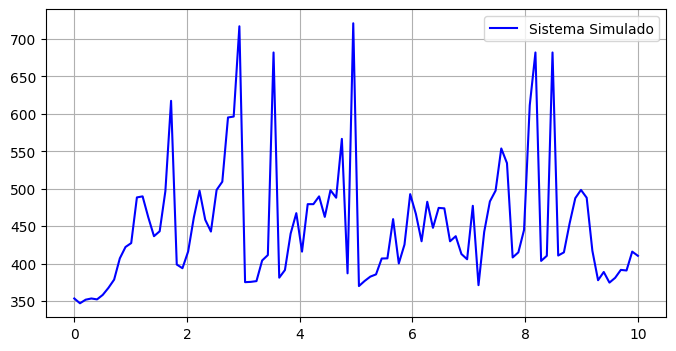

In [38]:
def simulateResponse(uData, Uo=0):
    n = 10
    states = Uo * np.ones(n)
    values = []

    for u in uData:
        for i in range(n-1, 0, -1):
            states[i] = states[i-1] # Xn3 = Xn2 ... Xn1 = Xn0

        states[0] = u # Xn
        yModel = model.predict([states])[0]
        values.append(yModel)

    return values


time   = np.linspace(0, 10, 100)
input  = [np.random.randint(50, 255) for i in time]
output = simulateResponse(input, Uo=255)

plt.figure(figsize=(8, 4))
plt.plot(time, output, color='blue', label='Sistema Simulado')
plt.grid(), plt.legend()
plt.show()

- **rData** é o sinal de referência, definido como uma função exponencial que converge para o valor setpoint = 6. Esse é o objetivo que o controlador tenta alcançar e simulamos um comportamento ideal

- **tData** é o vetor no tempo discreto tem o tamanho do horizonte de predição

- **uData** é o vetor de controle que contém os valores de entrada aplicados ao sistema para aproximá-lo do setpoint desejado. Inicialmente, é definido com valores constantes, mas será ajustado pela otimização para minimizar o erro entre a resposta do sistema e o objetivo.

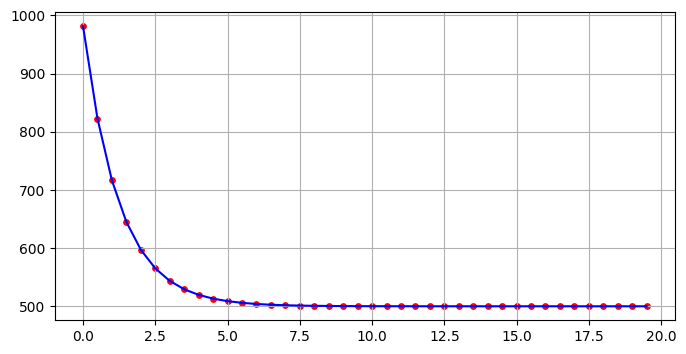

In [39]:
def getDesiredResponse(Ts, Xo, setpoint, dt):
    t = np.arange(0, P * dt, dt) 
    r = (-np.exp(-4/Ts*t) + 1)*(setpoint - Xo) + Xo
    return t, r


setpoint = 500
Ts = 5
dt = 0.5

Uo = 0 # COMEÇA DESLIGADO
Xo = simulateResponse([Uo], Uo)[0]

tData, rData = getDesiredResponse(Ts, Xo, setpoint, dt)
uData = np.linspace(limits[0], limits[1], M) # mudar

plt.figure(figsize=(8, 4))
plt.plot(tData, rData, color='blue')
plt.scatter(tData, rData, s=15, color='red')
plt.grid()
plt.show()

# TREINANDO MODELO
- A função abaixo calcula a soma dos quadrados dos erros para saber a distancia que estamos do objetivo (diferença entre o setpoint e a entrada), ou seja, é o erro com base nos valores de um vetor

In [40]:
def getError(uData, Uo=0):
    yData = simulateResponse(extend(uData, P), Uo=Uo)
    control_penalty   = np.sum(np.diff(uData) ** 2)  # Penaliza mudanças abruptas
    magnitude_penalty = np.sum(uData ** 2)           # Penaliza ações de controle grandes
    return np.sum((rData - yData) ** 2) + (0.2*control_penalty) + (0.01*magnitude_penalty)


getError(uData, Uo) # erro mt grande

1191913.0371144235

# MODELO
Com a medição do erro medido em objective, usamos scipy.optimize para encontrar a saída que minimiza esse erro, ou seja, qual é a entrada que temos que aplicar para minimizar esse erro

**OBS:** Para deixar mais rapido esta etapa, mude o campo method:
- **None**: Padrão
- **Nelder-Mead**: Método simplex, robusto, lento e sem suporte para limites ou restrições.
- **Powell**: Busca direcional, eficiente para problemas unidimensionais com limites.
- **CG**: Gradiente conjugado, rápido, mas sem suporte para limites ou restrições.
- **BFGS**: Quasi-Newton, eficiente para funções suaves sem limites ou restrições.
- **L-BFGS-B**: Variante do BFGS que suporta limites, ideal para problemas médios-grandes.
- **TNC**: Newton truncado, suporta limites simples, mas não restrições gerais.
- **COBYLA**: Método sem derivadas para problemas com restrições gerais.
- **SLSQP**: Suporta limites e restrições gerais com boa eficiência em problemas médios.
- **trust-constr**: Método robusto para problemas com limites e restrições complexas.
- **Newton-CG**: Usa gradientes e Hessiana, eficiente para problemas suaves e grandes.
- **Dogleg**: Baseado em segunda ordem, eficiente para pequenos problemas suaves.
- **Trust-Krylov**: Método avançado para grandes problemas suaves sem limites ou restrições.

In [41]:
result = scipy.optimize.minimize(getError, uData, args=(Uo,), bounds=bounds, method='L-BFGS-B')
result

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 767966.5963740118
        x: [ 4.499e+01  4.540e+01 ...  1.148e+02  1.102e+02]
      nit: 7
      jac: [ 7.334e-01  1.106e+00 ...  9.360e+00  3.492e-01]
     nfev: 2289
     njev: 109
 hess_inv: <20x20 LbfgsInvHessProduct with dtype=float64>

In [42]:
error = result.fun
error

767966.5963740118

# TESTANDO MODELO

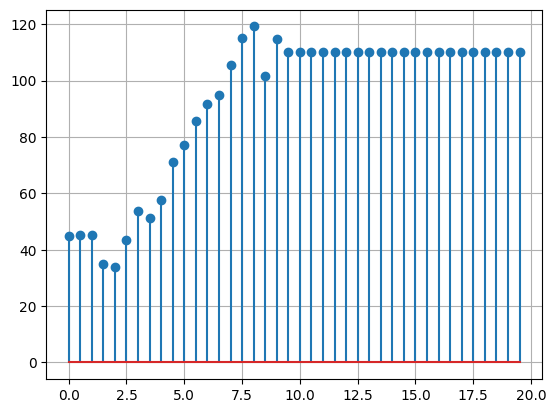

In [43]:
output = result.x
output = extend(output, P)

plt.stem(tData, output)
plt.grid()

In [44]:
len(result.x) == M # próximas 10 ações de conrole

True

Resample the discrete output to continuous time (effectively work out the 0 order hold value)

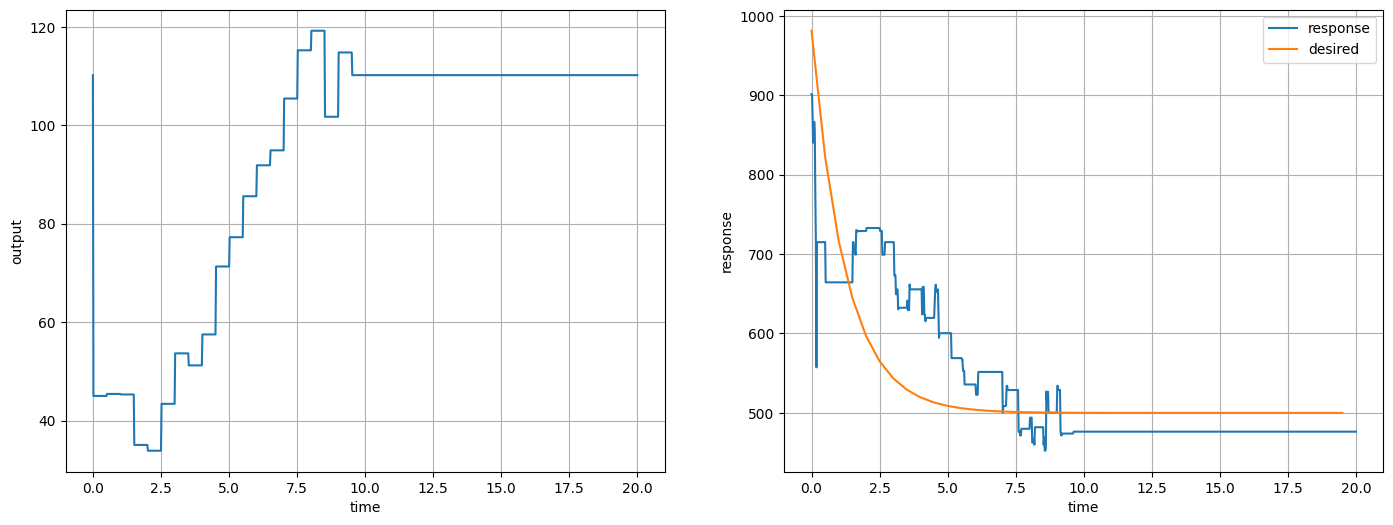

In [45]:
def getContinousArray(time, response, dt):
    indices = (time - 0.01) // dt
    return response[indices.astype(int)]


tData  = np.linspace(0, P*dt, 1000)  
output = getContinousArray(tData, output, dt)
yData  = simulateResponse(output)
t, y   = getDesiredResponse(Ts, Xo, setpoint, dt)

plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
plt.plot(tData, output)
plt.grid(), plt.xlabel('time'), plt.ylabel('output')
plt.subplot(1, 2, 2)
plt.plot(tData, yData, label='response')
plt.plot(t, y, label='desired')
plt.legend(), plt.xlabel('time'), plt.ylabel('response')
plt.grid()